In [22]:
import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Analyze one sample

In [3]:
data = pd.read_csv("E:/codex/CRC_clusters_neighborhoods_markers.csv", index_col=0)
features = [
       'CD44 - stroma:Cyc_2_ch_2', 'FOXP3 - regulatory T cells:Cyc_2_ch_3',
       'CD8 - cytotoxic T cells:Cyc_3_ch_2',
       'p53 - tumor suppressor:Cyc_3_ch_3',
       'GATA3 - Th2 helper T cells:Cyc_3_ch_4',
       'CD45 - hematopoietic cells:Cyc_4_ch_2', 'T-bet - Th1 cells:Cyc_4_ch_3',
       'beta-catenin - Wnt signaling:Cyc_4_ch_4', 'HLA-DR - MHC-II:Cyc_5_ch_2',
       'PD-L1 - checkpoint:Cyc_5_ch_3', 'Ki67 - proliferation:Cyc_5_ch_4',
       'CD45RA - naive T cells:Cyc_6_ch_2', 'CD4 - T helper cells:Cyc_6_ch_3',
       'CD21 - DCs:Cyc_6_ch_4', 'MUC-1 - epithelia:Cyc_7_ch_2',
       'CD30 - costimulator:Cyc_7_ch_3', 'CD2 - T cells:Cyc_7_ch_4',
       'Vimentin - cytoplasm:Cyc_8_ch_2', 'CD20 - B cells:Cyc_8_ch_3',
       'LAG-3 - checkpoint:Cyc_8_ch_4', 'Na-K-ATPase - membranes:Cyc_9_ch_2',
       'CD5 - T cells:Cyc_9_ch_3', 'IDO-1 - metabolism:Cyc_9_ch_4',
       'Cytokeratin - epithelia:Cyc_10_ch_2',
       'CD11b - macrophages:Cyc_10_ch_3', 'CD56 - NK cells:Cyc_10_ch_4',
       'aSMA - smooth muscle:Cyc_11_ch_2', 'BCL-2 - apoptosis:Cyc_11_ch_3',
       'CD25 - IL-2 Ra:Cyc_11_ch_4', 'CD11c - DCs:Cyc_12_ch_3',
       'PD-1 - checkpoint:Cyc_12_ch_4',
       'Granzyme B - cytotoxicity:Cyc_13_ch_2', 'EGFR - signaling:Cyc_13_ch_3',
       'VISTA - costimulator:Cyc_13_ch_4', 'CD15 - granulocytes:Cyc_14_ch_2',
       'ICOS - costimulator:Cyc_14_ch_4',
       'Synaptophysin - neuroendocrine:Cyc_15_ch_3',
       'GFAP - nerves:Cyc_16_ch_2', 'CD7 - T cells:Cyc_16_ch_3',
       'CD3 - T cells:Cyc_16_ch_4',
       'Chromogranin A - neuroendocrine:Cyc_17_ch_2',
       'CD163 - macrophages:Cyc_17_ch_3', 'CD45RO - memory cells:Cyc_18_ch_3',
       'CD68 - macrophages:Cyc_18_ch_4', 'CD31 - vasculature:Cyc_19_ch_3',
       'Podoplanin - lymphatics:Cyc_19_ch_4', 'CD34 - vasculature:Cyc_20_ch_3',
       'CD38 - multifunctional:Cyc_20_ch_4',
       'CD138 - plasma cells:Cyc_21_ch_3', 'HOECHST1:Cyc_1_ch_1',
       'CDX2 - intestinal epithelia:Cyc_2_ch_4',
       'Collagen IV - bas. memb.:Cyc_12_ch_2',
       'CD194 - CCR4 chemokine R:Cyc_14_ch_3',
       'MMP9 - matrix metalloproteinase:Cyc_15_ch_2',
       'CD71 - transferrin R:Cyc_15_ch_4', 'CD57 - NK cells:Cyc_17_ch_4',
       'MMP12 - matrix metalloproteinase:Cyc_21_ch_4', 'DRAQ5:Cyc_23_ch_4']

metadata = data.drop(features, axis=1)
data = data[features]

In [28]:
def feature_map(s):
    if ':' in s:
        s = s.split(':')[0]
    if ' - ' in s:
        s = s.split(' - ')[0]
    return s
short_features = list(map(feature_map, features))
short_features

['CD44',
 'FOXP3',
 'CD8',
 'p53',
 'GATA3',
 'CD45',
 'T-bet',
 'beta-catenin',
 'HLA-DR',
 'PD-L1',
 'Ki67',
 'CD45RA',
 'CD4',
 'CD21',
 'MUC-1',
 'CD30',
 'CD2',
 'Vimentin',
 'CD20',
 'LAG-3',
 'Na-K-ATPase',
 'CD5',
 'IDO-1',
 'Cytokeratin',
 'CD11b',
 'CD56',
 'aSMA',
 'BCL-2',
 'CD25',
 'CD11c',
 'PD-1',
 'Granzyme B',
 'EGFR',
 'VISTA',
 'CD15',
 'ICOS',
 'Synaptophysin',
 'GFAP',
 'CD7',
 'CD3',
 'Chromogranin A',
 'CD163',
 'CD45RO',
 'CD68',
 'CD31',
 'Podoplanin',
 'CD34',
 'CD38',
 'CD138',
 'HOECHST1',
 'CDX2',
 'Collagen IV',
 'CD194',
 'MMP9',
 'CD71',
 'CD57',
 'MMP12',
 'DRAQ5']

In [9]:
all_adata = sc.AnnData(data, obs=metadata)
all_adata.obsm['spatial'] = all_adata.obs[['X:X', 'Y:Y']].to_numpy()

LABEL_DICT = {k: i for i, k in enumerate(all_adata.obs['ClusterName'].unique())}

adatas = []
for i in all_adata.obs['patients'].unique():
    adatas.append(all_adata[all_adata.obs['patients'] == i])

datasets = []
for i in [0]:
    adata = adatas[i]
    data_dict = {}
    data_dict['raw_X'] = torch.from_numpy(adata.X.astype(np.float32))
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=64)
    sc.pp.scale(adata, zero_center=False)
    
    
    adata.var['highly_variable'] = True
    sq.gr.spatial_neighbors(adata, n_neighs=8)
    csr_matrix = adata.obsp['spatial_connectivities']

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


## Extract gene-gene attention

In [10]:
attn = torch.load("codex_out2/SpatialTransformer_pretrain/lr0.0001_weightdecay_0_cellmask_0.5_genemask_0.3_loss_sce_optim_adam_gamma_0.2_nneighs_8_ffn_58_dropout_0.1_mp_200_seed_42/encode_weights.pt")

In [12]:
attn.numpy()

array([[1.3676913e-11, 6.6277553e-11, 1.4959981e-01, ..., 1.6104295e-09,
        2.1406280e-11, 1.8770117e-11],
       [3.8486081e-25, 9.3772732e-21, 9.3550762e-23, ..., 1.1881521e-18,
        5.5978847e-22, 2.3439928e-22],
       [6.4410294e-08, 1.1965324e-17, 1.2819336e-19, ..., 5.3663767e-16,
        8.0344828e-19, 1.0923385e-18],
       ...,
       [7.1466757e-17, 4.4888951e-14, 1.4141157e-15, ..., 2.8279172e-13,
        3.4826979e-14, 2.7492229e-15],
       [6.3554150e-25, 2.9937786e-20, 3.1059173e-22, ..., 8.6529487e-19,
        1.2896477e-21, 4.3730667e-22],
       [2.4578144e-22, 3.2031789e-19, 8.0037511e-21, ..., 4.4481935e-18,
        3.6462315e-20, 1.0127228e-20]], dtype=float32)

In [13]:
Q = torch.load("codex_out2/SpatialTransformer_pretrain/lr0.0001_weightdecay_0_cellmask_0.5_genemask_0.3_loss_sce_optim_adam_gamma_0.2_nneighs_8_ffn_58_dropout_0.1_mp_200_seed_42/q.pt")
K = torch.load("codex_out2/SpatialTransformer_pretrain/lr0.0001_weightdecay_0_cellmask_0.5_genemask_0.3_loss_sce_optim_adam_gamma_0.2_nneighs_8_ffn_58_dropout_0.1_mp_200_seed_42/k.pt")

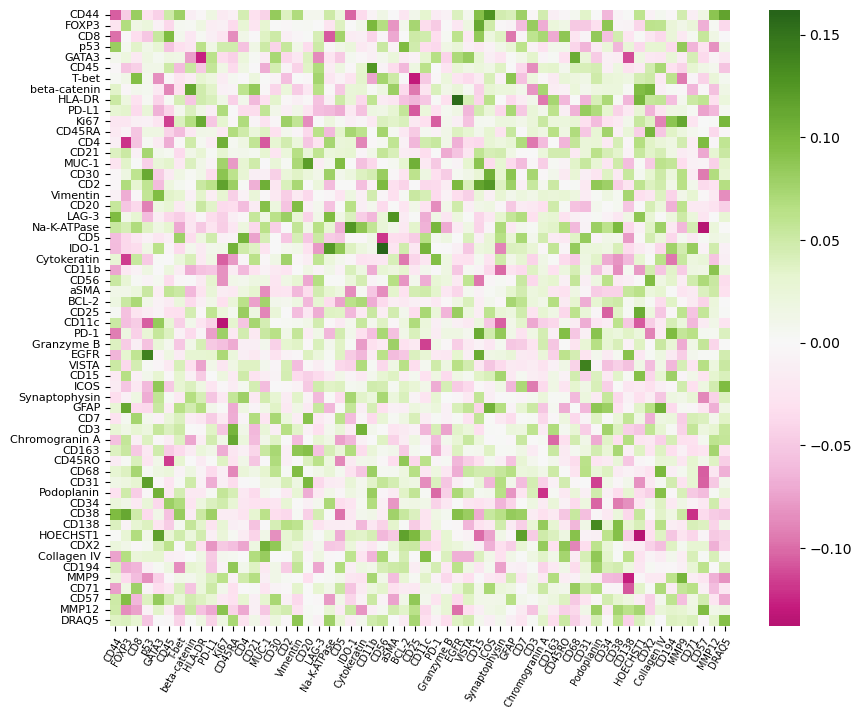

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(Q.numpy().T @ K.numpy(), cmap="PiYG", center=0)
plt.xticks(np.arange(len(short_features)) + 0.5, short_features, rotation=60, size=7, ha='right', va='top', rotation_mode='anchor')
plt.yticks(np.arange(len(short_features)) + 0.5, short_features, rotation=0, size=8)
pass

In [134]:
df = pd.melt(pd.DataFrame(Q.numpy().T @ K.numpy(), index=short_features, columns=short_features), ignore_index=False).reset_index().sort_values(by='value', ascending=False)
df.iloc[:15]

,index,variable,value
1472,IDO-1,CD56,0.162123
1864,HLA-DR,EGFR,0.156060
2585,VISTA,CD31,0.140839
206,EGFR,p53,0.140050
2658,CD138,Podoplanin,0.134724
2030,CD44,ICOS,0.128789
1527,LAG-3,aSMA,0.126406
1296,Na-K-ATPase,IDO-1,0.125033
1397,CD45,CD11b,0.124652
1182,IDO-1,Na-K-ATPase,0.123763


C:\Users\lshh\AppData\Local\Temp\ipykernel_55824\1211425486.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 9})


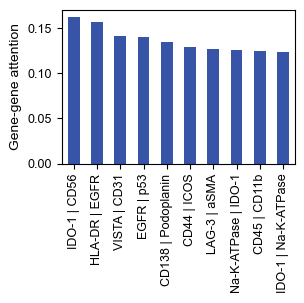

In [133]:
df['pair'] = df['index'] + ' | ' + df['variable']
df.iloc[:10].plot(kind='bar', x='pair', y='value', color='#3854a6', legend=None, figsize=(3, 2))
plt.xlabel("")
plt.ylabel("Gene-gene attention", font='Arial', size=10)
a = plt.gca()
a.set_xticklabels(a.get_xticklabels(), fontdict={'family': 'Arial', 'size': 9})
a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 9})

plt.savefig("fig5a.pdf", bbox_inches="tight")

## Extract cell-type attention

In [63]:
S_ = np.array(adata.obsp['spatial_connectivities'].todense().T)

In [126]:
cell_attns = attn.numpy()
cell_attns_2d = pd.DataFrame(0., index=adata.obs['ClusterName'].value_counts().index, columns=adata.obs['ClusterName'].value_counts().index)
for j in cell_attns_2d.index:
    for k in cell_attns_2d.columns:
        mask1 = (adata.obs['ClusterName'] == j)
        mask2 = (adata.obs['ClusterName'] == k)
        cell_attns_2d.loc[j, k] = np.sum(cell_attns[mask1, :][:, mask2] * S_[mask1, :][:, mask2]) / (S_[mask1, :][:, mask2].sum() + 1e-6)

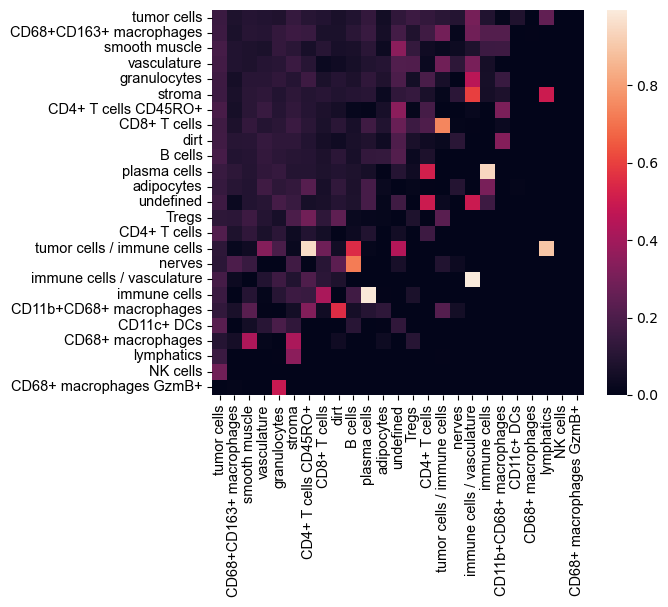

In [132]:
plt.figure(figsize=(6, 5))
sns.heatmap(cell_attns_2d)

a = plt.gca()
a.set_xticklabels(a.get_xticklabels(), fontdict={'family': 'Arial', 'size': 10.5})
a.set_yticklabels(a.get_yticklabels(), fontdict={'family': 'Arial', 'size': 10.5})

plt.xlabel("")
plt.ylabel("")

plt.savefig("fig5b.pdf", bbox_inches="tight")

In [128]:
df2 = pd.melt(cell_attns_2d, ignore_index=False)
df2.index.name = 'sender'
df2 = df2.reset_index().sort_values(by='value', ascending=False)
df2.iloc[:10]

,sender,ClusterName,value
442,immune cells / vasculature,immune cells / vasculature,0.995112
268,immune cells,plasma cells,0.987186
165,tumor cells / immune cells,CD4+ T cells CD45RO+,0.954262
460,plasma cells,immune cells,0.940700
565,tumor cells / immune cells,lymphatics,0.896806
382,CD8+ T cells,tumor cells / immune cells,0.743392
241,nerves,B cells,0.722287
430,stroma,immune cells / vasculature,0.596186
219,CD11b+CD68+ macrophages,dirt,0.553797
240,tumor cells / immune cells,B cells,0.551836
